In [1]:
%load_ext autoreload
%autoreload 2

## Импорт библиотек

In [70]:
import os
import sys
from collections import Counter, defaultdict

import pandas as pd
import plotly
import plotly.express as px
from qdrant_client import QdrantClient
from qdrant_client.models import (Distance, PointStruct, SearchParams,
                                  VectorParams)
from rich.progress import track
from sentence_transformers import SentenceTransformer
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm

sys.path.append(os.path.pardir)

from project_consts import PROJECT_ROOT

###  Подключаем wandb

In [3]:
import wandb

wandb.login()

wandb: Currently logged in as: alica154323 (starminalush). Use `wandb login --relogin` to force relogin


True

In [4]:
run = wandb.init(
    # set the wandb project where this run will be logged
    project="intents_classifier",
    name="labse-contrastive-loss-inference",
)

##  Константы

In [5]:
FILE_NAME = "intents_chat_bot_pervaya_lin-1000067115-HTA.json"
RAW_DATA_PATH = os.path.join(PROJECT_ROOT, "data", "raw", FILE_NAME)
PROCESSED_FOLDER_PATH = os.path.join(PROJECT_ROOT, "data", "processed")
VALIDATION_DATA_PATH = os.path.join(PROJECT_ROOT, "data", "raw", "sravni_dataset.xlsx")

## Получение данных

In [6]:
intents_df = pd.read_json(os.path.join(PROCESSED_FOLDER_PATH, "intents_prepared.json"))
intents_df.head()

,intent_id,intent_path,phrase
0,24174474,/Пересекающиеся/Продлить полис,продлить полис осаго
1,24174474,/Пересекающиеся/Продлить полис,мне нужно продлить полис
2,24174474,/Пересекающиеся/Продлить полис,нам нужно продлить полис страхования
3,24174474,/Пересекающиеся/Продлить полис,каким образом я могу продлить полис осаго от
4,24174474,/Пересекающиеся/Продлить полис,помогите продлить страховку


### Визуализация

In [7]:
def visualize_dist(df: pd.DataFrame, column_name: str, graph_filename: str) -> None:
    fig = px.histogram(df, y=column_name).update_yaxes(categoryorder="total ascending")
    fig.update_layout(
        yaxis={"dtick": 1},
        margin={"t": 100, "b": 100},
        height=len(df[column_name].unique()) * 11,
    )
    fig.write_html(graph_filename)
    plotly.offline.plot(fig, filename=graph_filename)

In [8]:
visualize_dist(
    intents_df, "intent_path", os.path.join(PROJECT_ROOT, "reports/intents.html")
)

##  Векторизация

Скачиваем модель

In [87]:
artifact = run.use_artifact(
    "starminalush/intents_classifier/run-bb7qjddx-labse-intents-contrastive:v0",
    type="model",
)
artifact_dir = artifact.download()

wandb: Downloading large artifact run-bb7qjddx-labse-intents-contrastive:v0, 1816.71MB. 13 files... 
wandb:   13 of 13 files downloaded.  
Done. 0:0:7.9


In [88]:
model = SentenceTransformer(
    os.path.join(
        PROJECT_ROOT, "notebooks/artifacts/run-bb7qjddx-labse-intents-contrastive:v0"
    )
)

In [89]:
client = QdrantClient(url="http://localhost:6333")
client.recreate_collection(
    collection_name="intents_collection",
    vectors_config=VectorParams(
        size=model.get_sentence_embedding_dimension(), distance=Distance.COSINE
    ),
)

/var/folders/t7/0zcbppxn02b4wfhmpbfg0f2m0000gn/T/ipykernel_3645/3783581583.py:2: DeprecationWarning:

`recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.



True

Заполняем базу векторами

In [90]:
client.upload_points(
    collection_name="intents_collection",
    points=[
        PointStruct(
            id=idx,
            vector=model.encode(row["phrase"]),
            payload={"intent_path": row["intent_path"]},
        )
        for idx, row in track(
            intents_df.iterrows(),
            description="Upload emb to qdrant...",
            total=len(intents_df),
        )
    ],
)

Output()

##  Поиск интентов

In [91]:
validation_df = pd.read_excel(VALIDATION_DATA_PATH)
validation_df.head(5)

,testCase,comment,request,expectedResponse,expectedState,skip,preActions
0,1,/Системные/Сценарии для оператора/Перевод сраз...,Прошу убрать из рассылок любого характера мой ...,NaN,/Сценарии для оператора Перевод сразу,NaN,NaN
1,2,/Кредиты-займы/Почему просроченный платеж,Здравствуйте. Я брал займ в мфо через приложен...,NaN,/ChatWithOperatorMfo,NaN,NaN
2,3,/Сравни ру/Внести изменения/Как изменить сведе...,Добрый день. Я оформила полис ОСАГО на вашем с...,NaN,/Внесение изменений/Полис,NaN,NaN
3,4,/Пересекающиеся/Не пришёл полис,"Два дня назад оплатил осаго, через сравни ру д...",NaN,/Не пришёл полис,NaN,NaN
4,5,/Кредиты-займы/Закрыть кредит,"Здравствуйте, я через вас взял займ в миг кред...",NaN,/ChatWithOperatorMfo,NaN,NaN


In [92]:
validation_df["comment"] = validation_df["comment"].apply(lambda x: x.strip())

In [93]:
visualize_dist(
    validation_df,
    "comment",
    os.path.join(PROJECT_ROOT, "reports/validation_intents.html"),
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [94]:
class VectorClassifier:
    def __init__(self, vector_model, vector_store):
        self._vector_model = vector_model
        self._vector_store = vector_store

    def classify(self, text, k=5) -> str:
        embedding = self._vector_model.encode(text)
        knn_result = self._vector_store.search(
            collection_name="intents_collection",
            query_vector=embedding,
            limit=k,
            search_params=SearchParams(exact=True),
        )
        intent_path = Counter([result.payload.get('intent_path') for result in knn_result]).most_common(1)[0][0]
        return intent_path

Посчитаем значения метрик при разном значении количества соседей K

In [95]:
f1_list, accuracy_list = list(), list()
classifier = VectorClassifier(vector_model=model, vector_store=client)
for k in tqdm(range(1, 25)):
    validation_df["model_predict_avg"] = validation_df.apply(
        lambda x: classifier.classify(x["request"], k=k), axis=1
    )
    accuracy = accuracy_score(
        validation_df["comment"], validation_df["model_predict_avg"]
    )
    f1 = f1_score(
        validation_df["comment"], validation_df["model_predict_avg"], average="macro"
    )
    f1_list.append(f1)
    accuracy_list.append(accuracy)

100%|███████████████████████████████████████████| 24/24 [07:19<00:00, 18.31s/it]


Визуалируем, при каком значении соседей K мы получим лучшую метрику F1-macro

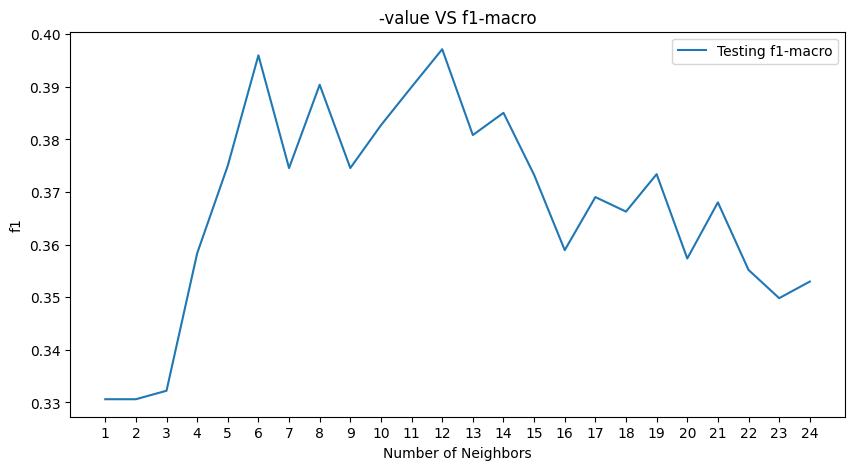

Best f1 is 0.3971692402090096 with K = 12
Accuracy score with best f1 is 0.5384615384615384


In [96]:
# Plot
plt.figure(figsize=[10, 5])
plt.plot(list(range(1, 25)),  f1_list, label = 'Testing f1-macro')
plt.legend()
plt.title('-value VS f1-macro')
plt.xlabel('Number of Neighbors')
plt.ylabel('f1')
plt.xticks(list(range(1, 25)))
plt.savefig('graph.png')
plt.show()
k = 1+f1_list.index(np.max(f1_list))
best_f1 = np.max(f1_list)
best_accuracy_with_f1 = accuracy_list[k-1]
print("Best f1 is {} with K = {}".format(best_f1, k))
print("Accuracy score with best f1 is {}".format(best_accuracy_with_f1))

## Логирование данных

In [22]:
validation_df.head()

,testCase,comment,request,expectedResponse,expectedState,skip,preActions,model_predict_top1,model_predict_avg
0,1,/Системные/Сценарии для оператора/Перевод сраз...,Прошу убрать из рассылок любого характера мой ...,NaN,/Сценарии для оператора Перевод сразу,NaN,NaN,/Системные/Сценарии для оператора/Перевод сраз...,/Системные/Сценарии для оператора/Перевод сраз...
1,2,/Кредиты-займы/Почему просроченный платеж,Здравствуйте. Я брал займ в мфо через приложен...,NaN,/ChatWithOperatorMfo,NaN,NaN,/Системные/Сценарии для оператора/Перевод сраз...,/Системные/Сценарии для оператора/Перевод сраз...
2,3,/Сравни ру/Внести изменения/Как изменить сведе...,Добрый день. Я оформила полис ОСАГО на вашем с...,NaN,/Внесение изменений/Полис,NaN,NaN,/Сравни ру/Внести изменения/Как изменить сведе...,/Проблемы/Проблемы в заполнении/Заполнение дан...
3,4,/Пересекающиеся/Не пришёл полис,"Два дня назад оплатил осаго, через сравни ру д...",NaN,/Не пришёл полис,NaN,NaN,/Пересекающиеся/Не пришёл полис/Не пришел поли...,/Пересекающиеся/Не пришёл полис/Не пришел поли...
4,5,/Кредиты-займы/Закрыть кредит,"Здравствуйте, я через вас взял займ в миг кред...",NaN,/ChatWithOperatorMfo,NaN,NaN,/Кредиты-займы/Оплатить займ,/Кредиты-займы/Оплатить займ


In [23]:
# логируем метрику и название модели
wandb.log({"accuracy": best_accuracy_with_f1})
wandb.log({"f1_macro": best_f1})

In [24]:
# логируем график
wandb.log(
    {
        "train_intents": wandb.Html(
            open(os.path.join(PROJECT_ROOT, "reports", "intents.html"))
        )
    }
)
wandb.log(
    {
        "validation_intents": wandb.Html(
            open(os.path.join(PROJECT_ROOT, "reports", "validation_intents.html"))
        )
    }
)

In [26]:
error_intents_avg = validation_df[
    validation_df["comment"] != validation_df["model_predict_avg"]
]
error_intents_avg.reset_index()
wandb.log({"error_intents_avg": wandb.Table(dataframe=error_intents_avg)})

In [27]:
wandb.finish()

accuracy_avg,▁
accuracy_top1,▁
f1_macro_avg,▁
f1_macro_top1,▁
accuracy_avg,0.44769
accuracy_top1,0.49231
f1_macro_avg,0.2969
f1_macro_top1,0.3306
